### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import warnings

### Database connection

In [2]:
connection_string = (
     "DRIVER={ODBC Driver 17 for SQL Server};"
     "SERVER=DESKTOP-T9651BF;"
     "DATABASE=SC_RUTAS_ENTREGAS;"
     "UID=carlosv;"
     "PWD=carlosv12345"
)

In [3]:
conn = pyodbc.connect(connection_string)

### Ignoring warnings

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning) 

### Data Exploration

In [5]:
query = "select * from dbo.clientes;"
df_clientes = pd.read_sql(query, conn)
df_clientes

,id_cliente,nombre,ubicacion,distancia_base_km
0,1,Estación Central,Av. Principal 123,50.0
1,2,Distribuidora Norte,"Calle 45, Sector B",120.0
2,3,Agropecuaria Fénix,Km 25 Vía Rural,85.0
3,4,PetroSur S.A.,Zona Industrial,90.0


In [6]:
query = "select * from dbo.camiones;"
df_camiones = pd.read_sql(query, conn)
df_camiones

,id_camion,placa_vehiculo,capacidad_lts,consumo_km_lts
0,1,P00-111,30000,2.5
1,2,P00-222,25000,2.0
2,3,P00-333,35000,1.5


In [6]:
query = "select * from dbo.entregas;"
df_entregas = pd.read_sql(query, conn)
df_entregas.head(6)

,id_entregas,id_camion,id_cliente,fecha_entrega,litros_entregados,entrega_minutos,km_recorridos,costo_combustible_lts
0,1,1,1,2024-09-01,25000,140,110.0,0.85
1,2,2,2,2024-09-01,20000,300,250.0,0.85
2,3,3,3,2024-09-02,30000,220,180.0,0.86
3,4,1,1,2024-09-02,28000,155,105.0,0.86
4,5,3,4,2024-09-03,32000,380,280.0,0.85
5,6,2,3,2024-09-03,24000,200,175.0,0.85


### Descriptive Analysis

In [24]:
df_entregas.drop(columns=['id_entregas', 'id_camion', 'id_cliente', 'fecha_entrega']).describe().round(2)

,litros_entregados,entrega_minutos,km_recorridos,costo_combustible_lts
count,30.00,30.00,30.00,30.00
mean,27216.67,262.60,202.07,0.90
std,4374.07,95.77,72.00,0.04
min,20000.00,140.00,105.00,0.85
25%,24125.00,170.00,126.50,0.87
50%,27500.00,227.50,180.00,0.89
75%,30000.00,350.00,267.50,0.93
max,35000.00,420.00,310.00,0.96


#### Identifying outliers

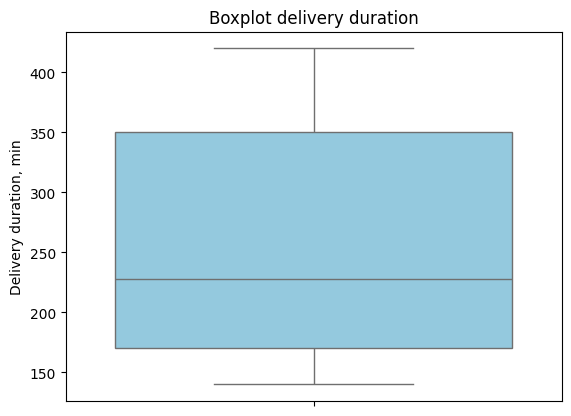

In [25]:
sns.boxplot(
    data=df_entregas,
    y='entrega_minutos',
    color = 'skyblue'
)
plt.title('Boxplot delivery duration')
plt.ylabel('Delivery duration, min')
plt.show()

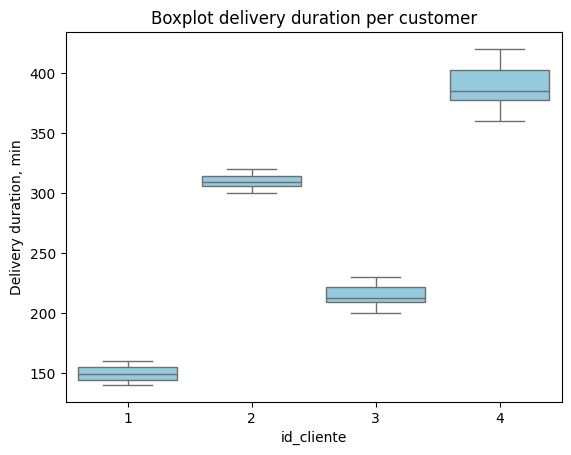

In [26]:
sns.boxplot(
    data=df_entregas,
    x='id_cliente',
    y='entrega_minutos',
    color='skyblue'
)
plt.title('Boxplot delivery duration per customer')
plt.ylabel('Delivery duration, min')
plt.show()

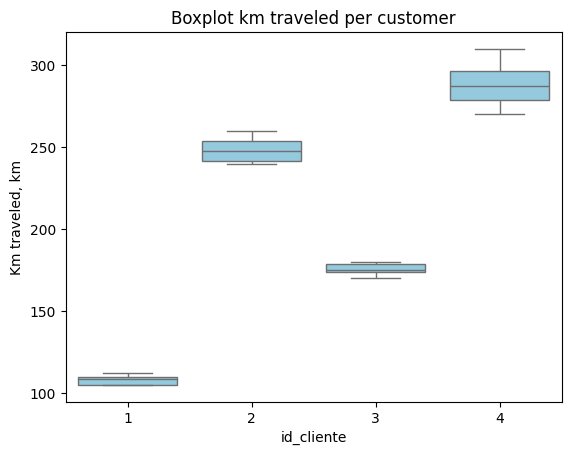

In [27]:
sns.boxplot(
    data=df_entregas,
    x='id_cliente',
    y='km_recorridos',
    color='skyblue'
)
plt.title('Boxplot km traveled per customer')
plt.ylabel('Km traveled, km')
plt.show()

### KPI: Time Efficiency (Delivery Duration)

In [11]:
query = """select c.nombre as cliente, 
        avg(e.entrega_minutos) as duracion_prom_min,
        round(avg(e.entrega_minutos / e.km_recorridos),1) as prom_minutos_por_km,
        case 
                when round(avg(e.entrega_minutos / e.km_recorridos),1) > 1.2 then 'Entrega Ineficiente'
                else 'Entrega Eficiente o Aceptable'
        end as estado_eficiencia
        from entregas e 
        join clientes c on e.id_cliente = c.id_cliente
        group by c.nombre
        order by prom_minutos_por_km desc;"""

df_prom_tiempo_recorrido = pd.read_sql(query, conn)
df_prom_tiempo_recorrido

,cliente,duracion_prom_min,prom_minutos_por_km,estado_eficiencia
0,Estación Central,149,1.4,Entrega Ineficiente
1,PetroSur S.A.,388,1.3,Entrega Ineficiente
2,Agropecuaria Fénix,214,1.2,Entrega Eficiente o Aceptable
3,Distribuidora Norte,309,1.2,Entrega Eficiente o Aceptable


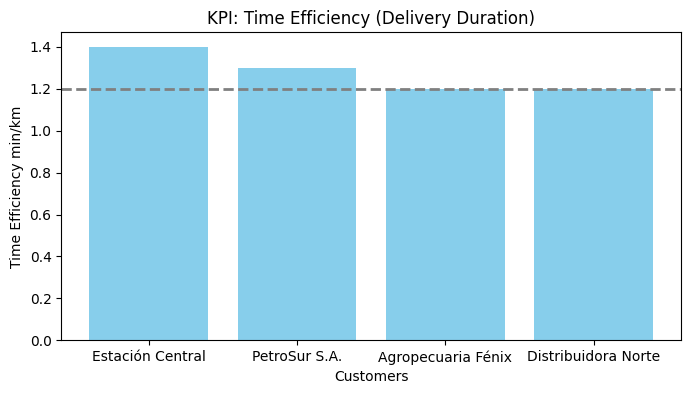

In [12]:
time_efficiency = 1.2 #company goal

plt.figure(figsize=(8, 4))

plt.bar(df_prom_tiempo_recorrido.cliente,
        df_prom_tiempo_recorrido.prom_minutos_por_km,
        color='skyblue')
plt.axhline(y=time_efficiency, color='gray', linestyle='--', linewidth=2)

plt.title('KPI: Time Efficiency (Delivery Duration)')
plt.xlabel('Customers')
plt.ylabel('Time Efficiency min/km')

plt.show()

#### KPI: Time Efficiency per Truck

In [13]:
query = """select c.id_camion as camiones,
                count(e.id_entregas) as viajes_por_camion,
                sum(e.km_recorridos) as total_recorrido,
                avg(e.km_recorridos) as prom_recorrido,
                sum(e.entrega_minutos) as total_duracion,
                avg(e.entrega_minutos) as prom_duracion
            from entregas e
            join camiones c on e.id_camion = c.id_camion
            group by c.id_camion;
        """
df_recorrido_camion = pd.read_sql(query, conn)
df_recorrido_camion

,camiones,viajes_por_camion,total_recorrido,prom_recorrido,total_duracion,prom_duracion
0,1,10,1895.0,189.5,2435,243
1,2,10,1862.0,186.2,2358,235
2,3,10,2305.0,230.5,3085,308


In [14]:
df_melted = df_recorrido_camion.melt(
    id_vars='camiones',
    value_vars=['prom_recorrido', 'prom_duracion'],
    var_name='Metric',
    value_name='Value'
)
df_melted

,camiones,Metric,Value
0,1,prom_recorrido,189.5
1,2,prom_recorrido,186.2
2,3,prom_recorrido,230.5
3,1,prom_duracion,243.0
4,2,prom_duracion,235.0
5,3,prom_duracion,308.0


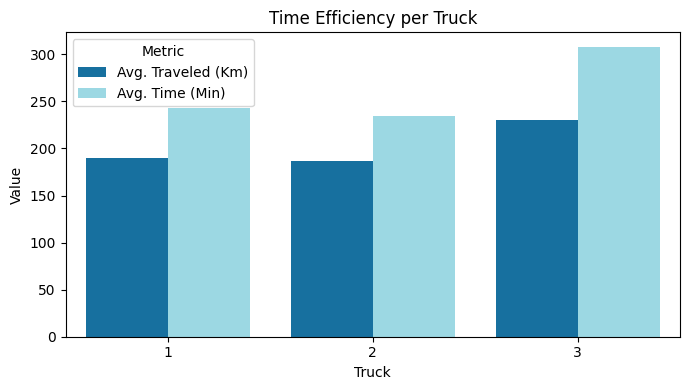

In [15]:
plt.figure(figsize=(7, 4))

colores = ['#0077b6', '#90e0ef']

sns.barplot(
    data=df_melted,
    x='camiones',
    y='Value',
    hue='Metric', 
    palette= colores
)

plt.title('Time Efficiency per Truck')
plt.xlabel('Truck')
plt.ylabel('Value')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Avg. Traveled (Km)', 'Avg. Time (Min)']
plt.legend(handles, new_labels, title='Metric')

plt.tight_layout()

plt.show()

#### KPI: Cost Efficiency (Fuel Consumption)

In [9]:
query = """select c.id_camion as camiones,
                count(e.id_entregas) as entregas_por_camion,
                round(sum(e.costo_combustible_lts * e.km_recorridos * c.consumo_km_lts),1) as costo_total_combust,
                round(avg(e.costo_combustible_lts * e.km_recorridos * c.consumo_km_lts),1) as costo_prom_combust,
                round(avg(e.costo_combustible_lts),3) as costo_prom_litros_combust
            from entregas e
            join camiones c on e.id_camion = c.id_camion
            group by c.id_camion;
        """
df_costo_camion = pd.read_sql(query, conn)
df_costo_camion


,camiones,entregas_por_camion,costo_total_combust,costo_prom_combust,costo_prom_litros_combust
0,1,10,4256.1,425.6,0.896
1,2,10,3353.3,335.3,0.900
2,3,10,3109.9,311.0,0.898


C:\Users\pc\AppData\Local\Temp\ipykernel_10724\2671511170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


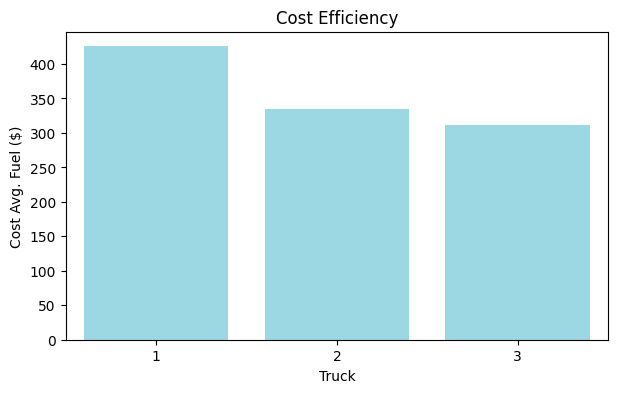

In [17]:
plt.figure(figsize=(7, 4))

colores = ['#90e0ef']

sns.barplot(
    data=df_costo_camion,
    x='camiones',
    y='costo_prom_combust', 
    palette= colores
)

plt.title('Cost Efficiency')
plt.xlabel('Truck')
plt.ylabel('Cost Avg. Fuel ($)')

plt.show()

#### KPI: Route Deviation Index

In [11]:
query =  """select c.nombre as cliente,
                sum(c.distancia_base_km * 2) as recorrido_teorico,
                sum(e.km_recorridos) as recorrido_real,
                sum(e.km_recorridos - (c.distancia_base_km * 2)) as desv_ruta_km,
				round(avg(e.km_recorridos - (c.distancia_base_km * 2)),2) as prom_desv_ruta_km,
                round(avg( ( (e.km_recorridos - (c.distancia_base_km * 2)) / (c.distancia_base_km * 2) )*100 ),2) as pct_desv_ruta
            from entregas e
            join clientes c on e.id_cliente = c.id_cliente
            group by c.nombre;
"""

df_indice_desv_ruta = pd.read_sql(query, conn)
df_indice_desv_ruta

,cliente,recorrido_teorico,recorrido_real,desv_ruta_km,prom_desv_ruta_km,pct_desv_ruta
0,Agropecuaria Fénix,1360.0,1403.0,43.0,5.38,3.16
1,Distribuidora Norte,1440.0,1490.0,50.0,8.33,3.47
2,Estación Central,800.0,864.0,64.0,8.00,8.00
3,PetroSur S.A.,1440.0,2305.0,865.0,108.13,60.07


In [12]:
df_melted = df_indice_desv_ruta.melt(
    id_vars='cliente',
    value_vars=['prom_desv_ruta_km', 'pct_desv_ruta'],
    var_name='Metric',
    value_name='Value'
)
df_melted

,cliente,Metric,Value
0,Agropecuaria Fénix,prom_desv_ruta_km,5.38
1,Distribuidora Norte,prom_desv_ruta_km,8.33
2,Estación Central,prom_desv_ruta_km,8.00
3,PetroSur S.A.,prom_desv_ruta_km,108.13
4,Agropecuaria Fénix,pct_desv_ruta,3.16
5,Distribuidora Norte,pct_desv_ruta,3.47
6,Estación Central,pct_desv_ruta,8.00
7,PetroSur S.A.,pct_desv_ruta,60.07


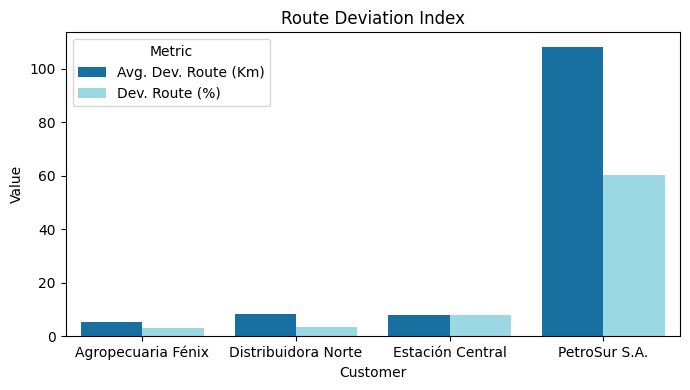

In [13]:
plt.figure(figsize=(7, 4))

colores = ['#0077b6', '#90e0ef']

sns.barplot(
    data=df_melted,
    x='cliente',
    y='Value',
    hue='Metric', 
    palette= colores
)

plt.title('Route Deviation Index')
plt.xlabel('Customer')
plt.ylabel('Value')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Avg. Dev. Route (Km)', 'Dev. Route (%)']
plt.legend(handles, new_labels, title='Metric')

plt.tight_layout()

plt.show()

#### Truck influence on Customer PetroSur S.A.

In [21]:
query = """with entregas_cliente_4 as (
                select e.id_entregas, e.id_camion, e.km_recorridos, e.entrega_minutos
                from entregas e
                join clientes c on e.id_cliente = c.id_cliente
                where c.nombre = 'PetroSur S.A.')
        select 
            id_camion,
            count(id_entregas) AS total_entregas_camion,
            (count(*) *100.0 / sum(count(*)) OVER ()) AS porcentaje_participacion,
            avg(km_recorridos) as prom_recorrido_camion,
            avg(entrega_minutos) as prom_tiempo_camion
            from entregas_cliente_4
            group by id_camion 
            order by porcentaje_participacion desc, prom_recorrido_camion desc, prom_tiempo_camion desc ;"""

df_influencia_camiones_clien4 = pd.read_sql(query, conn)
df_influencia_camiones_clien4

,id_camion,total_entregas_camion,porcentaje_participacion,prom_recorrido_camion,prom_tiempo_camion
0,3,5,62.5,295.0,400
1,1,2,25.0,280.0,365
2,2,1,12.5,270.0,380


In [14]:
conn.close()